In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
from tqdm import tqdm

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from underwriting import data_quality_checks

In [30]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    
    return df_summary_simp,df_cogs_average_product




In [31]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
CURRENT_MONTH = '2022-02'

In [32]:
ca_df = pd.read_csv('cali_comp.csv',index_col = 0)
ca_df.columns = ['company_name','company_identifier','state','licenses']
ca_df['company_identifier'] = ca_df['company_identifier'].astype(str)

In [33]:
ca_df_clean = ca_df[~ca_df['company_identifier'].isin(['PL','WHT','GF','UR'])]
ca_df_clean.shape

(42, 4)

In [94]:
len(ca_df_clean['company_identifier'].unique())

42

In [95]:
ca_df_clean

,company_name,company_identifier,state,licenses
0,99 High Tide,99HT,CA,C10-0000279-LIC
4,Budee,BUD,CA,C9-0000464-LIC;C9-0000467-LIC;C9-0000444-LIC;C...
6,Cali Greens LLC,CG,CA,C9-0000157-LIC
7,California Patients Alliance,CPA,CA,C10-0000461-LIC;C9-0000348-LIC
8,California Patients Club,CPC,CA,C9-0000056-LIC
9,California Street Cannabis,CSC,CA,C10-0000918-LIC;C10-0000670-LIC
10,California's Choice Collective,CCC,CA,C12-0000087-LIC
11,Calm and Collective,CC,CA,C10-0000758-LIC
15,Dubs Green Garden,DGG,CA,C9-0000016-LIC
17,E-Leaf,EL,CA,C9-0000370-LIC


In [35]:
def calculate_ca_gmv_change(company_identifier,transfer_packages_start_date,sales_transactrions_start_date,current_month):
    # setup
    df_summary_simp_list = {}
    quality_metric_list = list()
    # read data
    df_in,df_sales_deduped,bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts = data_quality_checks.run(company_identifier,transfer_packages_start_date,sales_transactrions_start_date)    
    licenses = df_sales_deduped['license_number'].unique()
    # loop thru locations
    for l in tqdm(licenses):
        print(l)
        df_in_l = df_in[df_in['license_number'] == l]
        df_sales_deduped_l = df_sales_deduped[df_sales_deduped['license_number'] == l]
        df_in_l['per_unit_incoming'] = df_in_l['shipper_wholesale_price'] / df_in_l['shipped_quantity']
        df_in_l = df_in_l[df_in_l['per_unit_incoming'] <= 10000]
        df_sales_l = df_sales_deduped_l
        df_summary_simp,df_cogs_average_product = cogs_analysis(df_in_l,df_sales_l,'monthly')
        df_summary_simp.index = df_summary_simp.date 
        # tax treatment
        df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
        df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
        df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
        df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']
        
        #revenue change
        df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()
        df_summary_simp['revenue_change_after_tax'] = df_summary_simp['revenue_after_tax'].pct_change()
        
        #rolling gm
        df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
        df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
        df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values
            
        df_summary_simp_list[l] = df_summary_simp
            
    quality_metric_list.append(list([bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts]))       
    return df_summary_simp_list,quality_metric_list
    

In [36]:
def get_ca_gmv_change_bm_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,current_month):
    cogs_df_list = {}
    quality_metric_list = {}
    for c in tqdm(company_list):
        print(c)
        cogs_df,quality_metric = calculate_ca_gmv_change([c],transfer_packages_start_date,sales_transactrions_start_date,current_month)
        cogs_df_list[c] = cogs_df
        quality_metric_list[c] = quality_metric
    return cogs_df_list,quality_metric_list
    
    

In [ ]:
#test out
#a,b = get_ca_gmv_change_bm_list(list(ca_df_clean['company_identifier'])[0:2],TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


# run

In [37]:
# no PL, WHT
# no GF (bad download history)
#UR: Data too big???

In [38]:
ca_cogs_df_list,ca_quality_metric_list = get_ca_gmv_change_bm_list(list(ca_df_clean['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


  0%|          | 0/42 [00:00<?, ?it/s]

99HT
Verifying download summaries for license C10-0000279-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
94.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 8164 (8.105719874105183%)
# transactions total: 100719
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 46637



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/42 [00:28<19:27, 28.47s/it]

BUD
Verifying download summaries for license C9-0000167-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000399-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000444-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000464-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000467-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
85.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 65133 (18.385856555711126%)
# transactions total: 354256
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing


  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:00<00:02,  1.70it/s]

C9-0000467-LIC



 40%|████      | 2/5 [00:00<00:01,  2.27it/s]

C9-0000399-LIC



 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

C9-0000444-LIC



 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

C9-0000167-LIC



  5%|▍         | 2/42 [01:20<28:03, 42.09s/it]

CG
Verifying download summaries for license C9-0000157-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 257 (1.248057498057498%)
# transactions total: 20592
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 11327



  7%|▋         | 3/42 [01:42<21:33, 33.16s/it]

C9-0000157-LIC
CPA
Verifying download summaries for license CCL19-0004859...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003278...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C9-0000348-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000461-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000844-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
91.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 5995 (1.500107597375625%)
# transactions total: 399638
# receipts with mismatching transactions: 0 (0.0%)
# rec


  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.67s/it]

C9-0000348-LIC



 10%|▉         | 4/42 [02:37<26:31, 41.89s/it]

CPC
Verifying download summaries for license C9-0000056-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-01

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 513 (0.8194102801648404%)
# transactions total: 62606
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 38338



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 12%|█▏        | 5/42 [03:02<22:01, 35.72s/it]

CSC
Verifying download summaries for license C10-0000670-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000918-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 248284
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 17 (0.012552610204533706%)
# receipts total: 135430



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


C10-0000918-LIC


 14%|█▍        | 6/42 [03:44<22:40, 37.80s/it]

CCC
Verifying download summaries for license C12-0000087-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C12-0000087-LIC on date 2022-02-20

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
86.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 16440 (5.0736982445744765%)
# transactions total: 324024
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 5 (0.002666382252559727%)
# receipts total: 187520



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 17%|█▋        | 7/42 [04:34<24:21, 41.76s/it]

CC
Verifying download summaries for license C10-0000758-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 27761
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 1 (0.005931549913992526%)
# receipts total: 16859



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 19%|█▉        | 8/42 [04:56<20:05, 35.45s/it]

DGG
Verifying download summaries for license C9-0000016-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000016-LIC on date 2022-02-22

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
94.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 1599 (4.540420819490587%)
# transactions total: 35217
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 15616



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 21%|██▏       | 9/42 [05:19<17:20, 31.52s/it]

EL
Verifying download summaries for license C9-0000370-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 20137
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 7874



 24%|██▍       | 10/42 [05:40<15:06, 28.34s/it]

C9-0000370-LIC
EMA
Verifying download summaries for license C10-0000774-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-03-08

Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-02-09

Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-02-09

Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2022-01-25
Latest download summary: 2022-02-09

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 42 unknown transfer packages
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 105363
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 46664



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 26%|██▌       | 11/42 [06:09<14:46, 28.59s/it]

EMF
Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2021-10-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 5929
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 2400



 29%|██▊       | 12/42 [06:29<12:54, 25.83s/it]

C10-0000939-LIC
EMM
Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2022-02-07
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 121622
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 57690



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 31%|███       | 13/42 [06:59<13:08, 27.19s/it]

EMT
Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2022-02-07
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 231558
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 108695



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 33%|███▎      | 14/42 [07:30<13:16, 28.46s/it]

GT
Verifying download summaries for license CDPH-10004633...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C9-0000170-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000170-LIC on date 2022-02-20

Verifying download summaries for license C9-0000385-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000385-LIC on date 2022-02-20

Verifying download summaries for license C11-0001267-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[FAILURE] Found a total of 2 bad download summaries
[SUCCESS] No unknown transfer packages!
27.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 419 (0.3985693358446055%)
# transactions total: 105126
# receipts with mismatching transactions: 0 (0.0%)
#


  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 36%|███▌      | 15/42 [07:59<12:52, 28.60s/it]

C9-0000170-LIC
GRG
Verifying download summaries for license C10-0000169-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000408-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 3961 (0.6378462985268827%)
# transactions total: 620996
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 314081



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000169-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.07s/it]

C10-0000408-LIC



 38%|███▊      | 16/42 [09:10<17:56, 41.40s/it]

GHC
Verifying download summaries for license CCL18-0000591...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003269...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000414-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000985-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 12836 (6.275944007392667%)
# transactions total: 204527
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 106254



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 40%|████      | 17/42 [09:48<16:47, 40.31s/it]

HB
Verifying download summaries for license CCL19-0004924...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003642...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000301-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000339-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000624-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000571-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
66.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer 


  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000339-LIC



 33%|███▎      | 1/3 [00:03<00:07,  3.96s/it]

C10-0000624-LIC



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


C10-0000301-LIC


 43%|████▎     | 18/42 [11:03<20:17, 50.74s/it]

HPCC
Verifying download summaries for license C10-0000005-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000064-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 21946 (1.7275186814622745%)
# transactions total: 1270377
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 580008



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:12<00:12, 12.37s/it]

C10-0000005-LIC



 45%|████▌     | 19/42 [13:52<33:03, 86.26s/it]

HC
Verifying download summaries for license C9-0000341-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
92.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 12696
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 6899



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC


 48%|████▊     | 20/42 [14:14<24:32, 66.92s/it]

IDC
Verifying download summaries for license C9-0000320-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 114160
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 62165



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 50%|█████     | 21/42 [14:44<19:29, 55.70s/it]

LBC
Verifying download summaries for license C9-0000154-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 310 (1.14441819255759%)
# transactions total: 27088
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 8505



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 52%|█████▏    | 22/42 [15:05<15:07, 45.37s/it]

ML
Verifying download summaries for license C9-0000300-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 122535
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 8 (0.017496282040066487%)
# receipts total: 45724



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 55%|█████▍    | 23/42 [15:39<13:16, 41.94s/it]

MW
Verifying download summaries for license C10-0000332-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 4176 (1.2434603691671853%)
# transactions total: 335837
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 16 (0.009264728022327995%)
# receipts total: 172698



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 57%|█████▋    | 24/42 [16:29<13:17, 44.28s/it]

MPW
Verifying download summaries for license C10-0000547-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 125 (0.02918222079034792%)
# transactions total: 428343
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 125 (0.06526972059338008%)
# receipts total: 191513



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 60%|█████▉    | 25/42 [17:25<13:36, 48.05s/it]

MD
Verifying download summaries for license C9-0000247-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 2251 (3.1988972260118236%)
# transactions total: 70368
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 25519



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 62%|██████▏   | 26/42 [17:51<11:00, 41.29s/it]

ND
Verifying download summaries for license C9-0000427-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
71.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 13229
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 3984



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC


 64%|██████▍   | 27/42 [18:11<08:43, 34.92s/it]

PRP
Verifying download summaries for license C10-0000759-LIC...
Earliest download summary: 2022-02-05
Latest download summary: 2022-03-08

Verifying download summaries for license C10-0000155-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-08

Verifying download summaries for license C10-0000286-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-08

Verifying download summaries for license C10-0000403-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 821 unknown transfer packages
94.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 44421 (5.932965146951777%)
# transactions total: 748715
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 316095



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:02<00:05,  2.83s/it]

C10-0000155-LIC



 67%|██████▋   | 2/3 [00:04<00:02,  2.20s/it]

C10-0000286-LIC



 67%|██████▋   | 28/42 [19:34<11:29, 49.28s/it]

PRL
Verifying download summaries for license C10-0000759-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-06

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 16054 (5.73812093874429%)
# transactions total: 279778
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 1 (0.0009451349180095459%)
# receipts total: 105805



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 69%|██████▉   | 29/42 [20:17<10:18, 47.61s/it]

RA
Verifying download summaries for license C10-0000596-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
94.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 132692
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 4 (0.006183909467565394%)
# receipts total: 64684



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 71%|███████▏  | 30/42 [20:50<08:38, 43.22s/it]

RGD
Verifying download summaries for license C9-0000057-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 51972
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 31034



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 74%|███████▍  | 31/42 [21:16<06:56, 37.85s/it]

SFV
Verifying download summaries for license CCL18-0001788...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003406...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000041-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000323-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 14947 (3.1280213961937213%)
# transactions total: 477842
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 3 (0.0010087017336220462%)
# receipts total: 297412



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 76%|███████▌  | 32/42 [22:29<08:05, 48.58s/it]

SV
Verifying download summaries for license C9-0000146-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 10333 (8.24042617669107%)
# transactions total: 125394
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 8 (0.021666711805649594%)
# receipts total: 36923



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 79%|███████▊  | 33/42 [23:01<06:30, 43.35s/it]

SLCC
Verifying download summaries for license C10-0000474-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 6223 (11.826751301835873%)
# transactions total: 52618
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 24143



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 81%|████████  | 34/42 [23:25<05:00, 37.57s/it]

SO
Verifying download summaries for license CCL19-0000839...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license CCL19-0004425...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C9-0000130-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C10-0000271-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C11-0000020-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C12-0000328-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 234 unknown transfer packages
85.0% of incoming transfer packages have receiver wholesale price
# transactions missing i


  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000271-LIC



 50%|█████     | 1/2 [00:01<00:01,  1.11s/it]

C9-0000130-LIC



 83%|████████▎ | 35/42 [24:02<04:21, 37.37s/it]

ST
Verifying download summaries for license C12-0000359-LIC...
Earliest download summary: 2022-01-03
Latest download summary: 2022-03-08

Verifying download summaries for license C9-0000323-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 540 (0.5343783398646241%)
# transactions total: 101052
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 48397



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 86%|████████▌ | 36/42 [24:29<03:27, 34.54s/it]

TGL
Verifying download summaries for license C9-0000412-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08
Found bad download summary for license C9-0000412-LIC on date 2021-12-29

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 4322
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 1650



 88%|████████▊ | 37/42 [24:49<02:29, 29.96s/it]

C9-0000412-LIC
TJR
Verifying download summaries for license C9-0000105-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 98602 (24.05220148798634%)
# transactions total: 409950
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 33305



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 90%|█████████ | 38/42 [25:52<02:39, 39.98s/it]

TT
Verifying download summaries for license C9-0000451-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0001391-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
77.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 113284
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 48199



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 93%|█████████▎| 39/42 [26:21<01:50, 36.69s/it]

T4L
Verifying download summaries for license C12-0000302-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
86.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 229 (1.4572992236222477%)
# transactions total: 15714
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 7632



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000302-LIC



 95%|█████████▌| 40/42 [26:42<01:04, 32.09s/it]

UHHC
Verifying download summaries for license CCL19-0004871...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003448...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003451...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C9-0000082-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000817-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000827-LIC...
Earliest download summary: 2021-12-26
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000313-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[FAILURE] Fxo


  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000082-LIC



 98%|█████████▊| 41/42 [27:12<00:31, 31.20s/it]

C10-0000817-LIC
VOY
Verifying download summaries for license C10-0000802-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

Verifying download summaries for license C12-0000030-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

Verifying download summaries for license C12-0000159-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

Verifying download summaries for license C12-0000175-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 13757 unknown transfer packages
15.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 4824
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 1987



100%|██████████| 42/42 [27:36<00:00, 39.43s/it]

C10-0000802-LIC


In [39]:
ca_cogs_df_list.keys()

dict_keys(['99HT', 'BUD', 'CG', 'CPA', 'CPC', 'CSC', 'CCC', 'CC', 'DGG', 'EL', 'EMA', 'EMF', 'EMM', 'EMT', 'GT', 'GRG', 'GHC', 'HB', 'HPCC', 'HC', 'IDC', 'LBC', 'ML', 'MW', 'MPW', 'MD', 'ND', 'PRP', 'PRL', 'RA', 'RGD', 'SFV', 'SV', 'SLCC', 'SO', 'ST', 'TGL', 'TJR', 'TT', 'T4L', 'UHHC', 'VOY'])

# output data

In [40]:
df = pd.DataFrame()
for k in ca_cogs_df_list.keys():
    print(k)
    for l in ca_cogs_df_list[k].keys():
        print(l)
        data = ca_cogs_df_list[k][l]
        data['company'] = k
        data['location'] = l
        print(data.shape)
        df = df.append(data)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(15, 20)
BUD
C9-0000464-LIC
(5, 20)
C9-0000467-LIC
(4, 20)
C9-0000399-LIC
(12, 20)
C9-0000444-LIC
(4, 20)
C9-0000167-LIC
(11, 20)
CG
C9-0000157-LIC
(25, 20)
CPA
C10-0000461-LIC
(26, 20)
C9-0000348-LIC
(16, 20)
CPC
C9-0000056-LIC
(19, 20)
CSC
C10-0000670-LIC
(27, 20)
C10-0000918-LIC
(4, 20)
CCC
C12-0000087-LIC
(27, 20)
CC
C10-0000758-LIC
(13, 20)
DGG
C9-0000016-LIC
(27, 20)
EL
C9-0000370-LIC
(19, 20)
EMA
C10-0000774-LIC
(15, 20)
EMF
C10-0000939-LIC
(2, 20)
EMM
C10-0000786-LIC
(13, 20)
EMT
C10-0000695-LIC
(22, 20)
GT
C9-0000385-LIC
(5, 20)
C9-0000170-LIC
(9, 20)
GRG
C10-0000169-LIC
(27, 20)
C10-0000408-LIC
(8, 20)
GHC
C10-0000414-LIC
(17, 20)
HB
C10-0000339-LIC
(27, 20)
C10-0000624-LIC
(27, 20)
C10-0000301-LIC
(20, 20)
HPCC
C10-0000064-LIC
(27, 20)
C10-0000005-LIC
(27, 20)
HC
C9-0000341-LIC
(13, 20)
IDC
C9-0000320-LIC
(24, 20)
LBC
C9-0000154-LIC
(23, 20)
ML
C9-0000300-LIC
(21, 20)
MW
C10-0000332-LIC
(27, 20)
MPW
C10-0000547-LIC
(21, 20)
MD
C9-0000247-LIC
(27, 20)
ND


In [14]:
#df.to_csv('ca_analysis_0307.csv')

In [ ]:
#df.to_excel('ca_location_analysis/'+'ca_analysis.xlsx')

In [112]:
df

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,revenue_change,revenue_change_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,company,location,id
0,2021-01,291646.25,69941.447555,221704.802445,0.760184,4808.0,2003.0,2805,0.696005,335393.1875,88825.638395,246567.549105,0.735160,NaN,NaN,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
1,2021-02,262906.73,85322.341897,177584.388103,0.675465,5464.0,377.0,5087,0.948611,302342.7395,108359.374209,193983.365291,0.641601,-0.098542,-0.098542,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
2,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.198732,0.198732,0.675507,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
3,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.046868,0.046868,0.651166,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
4,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.020818,0.020818,0.662373,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2021-11,18761.21,5470.325953,13290.884047,0.708424,610.0,52.0,558,0.884058,21575.3915,6947.313960,14628.077540,0.677998,0.111837,0.111837,0.591387,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
995,2021-12,32715.38,12198.903894,20516.476106,0.627120,1062.0,129.0,933,0.919481,37622.6870,15492.607945,22130.079055,0.588211,0.743778,0.743778,0.644411,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
996,2022-01,24339.01,11123.403847,13215.606153,0.542980,831.0,43.0,788,0.936866,27989.8615,14126.722885,13863.138615,0.495291,-0.256038,-0.256038,0.587167,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
997,2022-02,24450.82,10410.082937,14040.737063,0.574244,796.0,37.0,759,0.953293,28118.4430,13220.805331,14897.637669,0.529817,0.004594,0.004594,0.537773,0.564580,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"


In [42]:
df['id'] = list(zip(df.company, df.location))

In [43]:
df = df.reset_index(drop = True)

In [113]:
df.head()

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,revenue_change,revenue_change_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,company,location,id
0,2021-01,291646.25,69941.447555,221704.802445,0.760184,4808.0,2003.0,2805,0.696005,335393.1875,88825.638395,246567.549105,0.735160,NaN,NaN,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
1,2021-02,262906.73,85322.341897,177584.388103,0.675465,5464.0,377.0,5087,0.948611,302342.7395,108359.374209,193983.365291,0.641601,-0.098542,-0.098542,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
2,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.198732,0.198732,0.675507,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
3,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.046868,0.046868,0.651166,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
4,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.020818,0.020818,0.662373,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"


In [119]:
df_high_coverage = df[df['coverage'] >= 0.7]

In [149]:
df_high_coverage

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,revenue_change,revenue_change_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,company,location,id
1,2021-02,262906.73,85322.341897,177584.388103,0.675465,5464.0,377.0,5087,0.948611,302342.7395,108359.374209,193983.365291,0.641601,-0.098542,-0.098542,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
2,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.198732,0.198732,0.675507,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
3,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.046868,0.046868,0.651166,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
4,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.020818,0.020818,0.662373,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
5,2021-06,324788.69,98065.517011,226723.172989,0.698064,6860.0,114.0,6746,0.926026,373506.9935,124543.206604,248963.786896,0.666557,-0.035645,-0.035645,0.667972,0.671739,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2021-11,18761.21,5470.325953,13290.884047,0.708424,610.0,52.0,558,0.884058,21575.3915,6947.313960,14628.077540,0.677998,0.111837,0.111837,0.591387,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
995,2021-12,32715.38,12198.903894,20516.476106,0.627120,1062.0,129.0,933,0.919481,37622.6870,15492.607945,22130.079055,0.588211,0.743778,0.743778,0.644411,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
996,2022-01,24339.01,11123.403847,13215.606153,0.542980,831.0,43.0,788,0.936866,27989.8615,14126.722885,13863.138615,0.495291,-0.256038,-0.256038,0.587167,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
997,2022-02,24450.82,10410.082937,14040.737063,0.574244,796.0,37.0,759,0.953293,28118.4430,13220.805331,14897.637669,0.529817,0.004594,0.004594,0.537773,0.564580,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"


In [148]:
len(df_high_coverage['location'].unique())

57

In [144]:
df_high_coverage[['date','id']].groupby(['date']).count()

,id
date,
2020-01,6
2020-02,14
2020-03,18
2020-04,19
2020-05,21
2020-06,23
2020-07,25
2020-08,27
2020-09,26


# 3m

In [121]:
df_high_coverage_3m_trim = df_high_coverage[(df_high_coverage['gm_past_quarter_after_tax'] > 0.2) & (df_high_coverage['gm_past_quarter_after_tax'] < 0.8)]



In [124]:
#df_high_coverage_3m_trim.shape[0] / df_high_coverage.shape[0]

In [120]:
df_high_coverage.head()

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,revenue_change,revenue_change_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,company,location,id
1,2021-02,262906.73,85322.341897,177584.388103,0.675465,5464.0,377.0,5087,0.948611,302342.7395,108359.374209,193983.365291,0.641601,-0.098542,-0.098542,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
2,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.198732,0.198732,0.675507,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
3,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.046868,0.046868,0.651166,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
4,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.020818,0.020818,0.662373,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
5,2021-06,324788.69,98065.517011,226723.172989,0.698064,6860.0,114.0,6746,0.926026,373506.9935,124543.206604,248963.786896,0.666557,-0.035645,-0.035645,0.667972,0.671739,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"


In [125]:
orig_gm_past_3m = df_high_coverage_3m_trim[df_high_coverage_3m_trim['gm_past_quarter_after_tax'] > 0][['id','date']].groupby(['date']).count()
orig_gm_dolloar = df_high_coverage_3m_trim[df_high_coverage_3m_trim['gm_past_quarter_after_tax'] > 0][['margin_$_after_tax','date']].groupby(['date']).mean()
for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df_high_coverage_3m_trim[df_high_coverage_3m_trim['gm_past_quarter_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join_med_margin_dolloar = qualify[['margin_$_after_tax','date']].groupby(['date']).mean()
    to_join.columns = [str(round(i,2))]
    to_join_med_margin_dolloar.columns = [str(round(i,2))]
    orig_gm_past_3m = pd.concat([orig_gm_past_3m,to_join],axis = 1,join = 'outer')
    orig_gm_dolloar = pd.concat([orig_gm_dolloar,to_join_med_margin_dolloar],axis = 1,join = 'outer')

0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6


In [126]:
orig_gm_past_3m

,id,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6
date,,,,,,,,,,,,,,,,,,,,,,
2020-03,13,12,12,12,12,12,11,11,11,11,10,10,9,9,9,8,8,8,8,8,8,8
2020-04,14,13,13,13,12,12,12,11,11,11,10,10,9,8,8,8,7,6,5,3,3,3
2020-05,17,15,15,15,15,15,14,14,13,11,11,9,9,8,7,6,4,3,3,3,3,3
2020-06,18,16,16,16,15,15,15,14,14,13,12,10,8,8,7,5,4,4,4,4,4,4
2020-07,20,17,16,16,16,16,16,15,15,14,10,10,9,9,8,7,7,4,4,4,4,4
2020-08,22,18,17,17,16,16,16,16,13,12,10,9,9,9,9,7,7,6,5,5,5,4
2020-09,23,19,19,17,17,17,17,16,14,13,12,9,9,9,9,8,8,5,5,5,4,4
2020-10,24,20,20,18,18,18,18,17,15,15,13,12,12,11,11,9,8,7,6,6,5,5
2020-11,25,22,21,20,19,19,19,18,15,13,13,13,13,13,10,9,7,7,7,7,5,5


In [200]:
df_high_coverage_3m_trim

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,revenue_change,revenue_change_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,company,location,id
2,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.198732,0.198732,0.675507,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
3,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.046868,0.046868,0.651166,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
4,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.020818,0.020818,0.662373,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
5,2021-06,324788.69,98065.517011,226723.172989,0.698064,6860.0,114.0,6746,0.926026,373506.9935,124543.206604,248963.786896,0.666557,-0.035645,-0.035645,0.667972,0.671739,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
6,2021-07,350888.53,110980.195080,239908.334920,0.683717,7866.0,40.0,7826,0.954843,403521.8095,140944.847752,262576.961748,0.650713,0.080359,0.080359,0.664164,0.657665,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2021-11,18761.21,5470.325953,13290.884047,0.708424,610.0,52.0,558,0.884058,21575.3915,6947.313960,14628.077540,0.677998,0.111837,0.111837,0.591387,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
995,2021-12,32715.38,12198.903894,20516.476106,0.627120,1062.0,129.0,933,0.919481,37622.6870,15492.607945,22130.079055,0.588211,0.743778,0.743778,0.644411,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
996,2022-01,24339.01,11123.403847,13215.606153,0.542980,831.0,43.0,788,0.936866,27989.8615,14126.722885,13863.138615,0.495291,-0.256038,-0.256038,0.587167,NaN,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"
997,2022-02,24450.82,10410.082937,14040.737063,0.574244,796.0,37.0,759,0.953293,28118.4430,13220.805331,14897.637669,0.529817,0.004594,0.004594,0.537773,0.564580,NaN,VOY,C10-0000802-LIC,"(VOY, C10-0000802-LIC)"


In [206]:
df_high_coverage_3m_trim[['date','margin_%_after_tax']].groupby(['date']).quantile(.9)

,margin_%_after_tax
date,
2020-03,0.629226
2020-04,0.611574
2020-05,0.639946
2020-06,0.624768
2020-07,0.648600
2020-08,0.650157
2020-09,0.645400
2020-10,0.676324
2020-11,0.633820


In [176]:
df_high_coverage_3m_trim[(df_high_coverage_3m_trim['revenue'] >= 3.307699e+05)][['date','gm_past_quarter_after_tax']].groupby(['date']).quantile(.75)



,gm_past_quarter_after_tax
date,
2020-03,0.671020
2020-04,0.575779
2020-05,0.587735
2020-06,0.512361
2020-07,0.594043
2020-08,0.575867
2020-09,0.575156
2020-10,0.616386
2020-11,0.687499


<AxesSubplot:xlabel='date'>

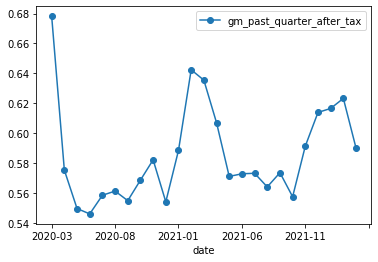

In [198]:
df_high_coverage_3m_trim[['date','gm_past_quarter_after_tax']].groupby(['date']).quantile(.75).plot(marker = 'o')

In [128]:
# orig_gm_dolloar.mean(axis = 0).plot(marker = 'o',label = 'mean')
# orig_gm_dolloar.median(axis = 0).plot(marker = 'o',label = 'median')
# plt.legend()

In [ ]:
# orig_gm_dolloar['0.48'].plot()
# orig_gm_dolloar['0.55'].plot()
# plt.legend()

# 6m

In [132]:
df_high_coverage_6m_trim = df_high_coverage[(df_high_coverage['gm_past_2quarters_after_tax'] > 0.2) & (df_high_coverage['gm_past_2quarters_after_tax'] < 0.8)]



<AxesSubplot:xlabel='date'>

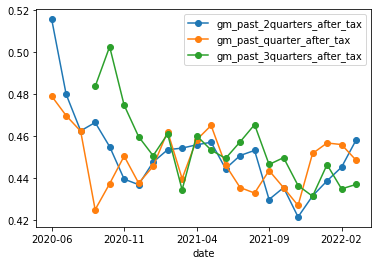

In [197]:
df_high_coverage_6m_trim[['date','gm_past_2quarters_after_tax','gm_past_quarter_after_tax','gm_past_3quarters_after_tax']].groupby(['date']).quantile(.25).plot(marker = 'o')

In [133]:
orig_gm_past_6m = df_high_coverage_6m_trim[df_high_coverage_6m_trim['gm_past_2quarters_after_tax'] > 0][['id','date']].groupby(['date']).count()
for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df_high_coverage_6m_trim[df_high_coverage_6m_trim['gm_past_2quarters_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join.columns = [str(round(i,2))]
    orig_gm_past_6m = pd.concat([orig_gm_past_6m,to_join],axis = 1,join = 'outer')

0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6


In [134]:
orig_gm_past_6m

,id,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6
date,,,,,,,,,,,,,,,,,,,,,,
2020-06,13,12,12,12,12,12,12,12,12,12,10,10,10,9,9,9,8,8,7,6,5,3
2020-07,15,14,14,14,14,14,14,14,13,11,10,9,8,8,7,6,6,4,4,4,4,4
2020-08,17,14,14,13,13,13,13,13,12,11,9,8,8,8,8,6,5,4,4,3,3,3
2020-09,18,14,14,14,14,14,14,14,13,13,10,9,8,7,6,6,4,3,3,3,3,3
2020-10,19,17,16,16,15,15,14,14,12,11,10,10,9,9,9,8,6,4,4,4,4,4
2020-11,20,17,16,15,15,15,14,14,12,11,11,11,10,10,9,9,6,6,6,6,5,4
2020-12,24,20,19,19,18,17,16,14,13,12,12,11,11,11,11,9,7,7,7,7,5,5
2021-01,24,21,19,19,19,19,17,16,14,14,13,12,12,12,10,9,8,7,7,7,6,5
2021-02,26,21,21,20,20,20,20,19,16,15,15,15,14,13,11,11,9,9,8,8,7,7


In [199]:
df_high_coverage_6m_trim[['date','gm_past_2quarters_after_tax']].groupby(['date']).quantile(1)

,gm_past_2quarters_after_tax
date,
2020-06,0.698684
2020-07,0.768598
2020-08,0.740726
2020-09,0.716650
2020-10,0.707062
2020-11,0.697060
2020-12,0.697827
2021-01,0.691017
2021-02,0.704325


# 9m

In [138]:
df_high_coverage_9m_trim = df_high_coverage[(df_high_coverage['gm_past_3quarters_after_tax'] > 0.2) & (df_high_coverage['gm_past_3quarters_after_tax'] < 0.8)]



In [139]:
orig_gm_past_9m = df_high_coverage_9m_trim[df_high_coverage_9m_trim['gm_past_3quarters_after_tax'] > 0][['id','date']].groupby(['date']).count()
for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df_high_coverage_9m_trim[df_high_coverage_9m_trim['gm_past_3quarters_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join.columns = [str(round(i,2))]
    orig_gm_past_9m = pd.concat([orig_gm_past_9m,to_join],axis = 1,join = 'outer')

0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6


In [140]:
orig_gm_past_9m

,id,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6
date,,,,,,,,,,,,,,,,,,,,,,
2020-09,13,12,12,12,12,12,12,12,12,10,9,9,8,8,8,8,8,6,5,4,4,3
2020-10,13,12,12,12,12,12,12,12,10,10,10,10,9,7,7,6,5,3,3,3,3,3
2020-11,15,13,13,13,13,13,13,13,11,11,10,8,8,8,8,6,4,3,3,3,3,3
2020-12,18,15,15,15,15,15,15,14,12,11,10,9,9,9,8,7,5,5,5,5,5,5
2021-01,19,18,17,15,15,15,15,15,12,11,11,10,10,10,9,8,6,6,6,6,5,5
2021-02,22,19,18,18,18,18,18,18,15,14,14,14,13,12,11,10,8,8,7,7,6,6
2021-03,24,21,20,19,18,17,17,16,14,13,13,12,12,12,11,8,7,7,7,7,6,6
2021-04,25,22,21,21,20,20,20,19,15,15,15,15,14,13,11,10,9,9,9,9,7,7
2021-05,26,23,22,22,22,21,21,18,16,16,16,16,15,13,12,11,10,10,10,9,8,8


In [143]:
df_high_coverage_9m_trim[['date','gm_past_3quarters_after_tax']].groupby(['date']).quantile(.75)

,gm_past_3quarters_after_tax
date,
2020-09,0.599458
2020-10,0.553057
2020-11,0.552531
2020-12,0.587608
2021-01,0.605312
2021-02,0.615298
2021-03,0.596255
2021-04,0.613187
2021-05,0.620320


# percentile

In [83]:
def calculate_percentile(n_list):
    return [stats.percentileofscore(n_list.dropna(),i, kind='weak') for i in n_list.dropna()]

In [91]:
df[df['date'] =='2021-01']['gm_past_quarter_after_tax'].dropna()

42     0.858547
63     0.426074
87     0.476736
123    0.617865
149    0.396028
180    0.762602
220    0.638783
239    0.570947
291    0.588489
332    0.659297
357    0.823127
384    0.854166
411    0.747100
436    0.502389
458    0.487453
485    0.516106
522    0.476785
545    0.627987
566    0.425549
593    0.523930
614    0.330898
641    0.543356
734    0.541038
757    0.385044
784    0.676658
842    0.495355
866    0.324776
890    0.466002
947    0.451888
974    0.454062
Name: gm_past_quarter_after_tax, dtype: float64

In [84]:
calculate_percentile(df[df['date'] =='2021-01']['gm_past_quarter_after_tax'])

[100.0,
 20.0,
 33.33333333333333,
 70.0,
 13.333333333333334,
 90.0,
 76.66666666666667,
 63.33333333333333,
 66.66666666666666,
 80.0,
 93.33333333333333,
 96.66666666666667,
 86.66666666666667,
 46.666666666666664,
 40.0,
 50.0,
 36.666666666666664,
 73.33333333333333,
 16.666666666666664,
 53.333333333333336,
 6.666666666666667,
 60.0,
 56.666666666666664,
 10.0,
 83.33333333333334,
 43.333333333333336,
 3.3333333333333335,
 30.0,
 23.333333333333332,
 26.666666666666668]

In [73]:
from scipy import stats
stats.percentileofscore(df['gm_past_quarter_after_tax'].dropna(),0 , kind='weak')

3.2768361581920904

In [150]:
## flowhub

In [158]:
fh = pd.read_csv('flowhub_batch2_location_analysis_0222.csv',index_col= 0)

In [160]:
fh[fh['location_state'] == 'CA']['margin_perc'].describe()

count    475.000000
mean       0.384483
std        0.481382
min       -9.777147
25%        0.350838
50%        0.397753
75%        0.456211
max        0.865823
Name: margin_perc, dtype: float64

# flowhub

In [161]:
fh = pd.read_csv('margin_distr_trim_after_tax_0310.csv',index_col= 0)

In [162]:
fh

,location_state,year_month,count,mean,std,min,25%,50%,75%,max
0,CA,2021-01-01,28.0,0.502708,0.069428,0.387380,0.453453,0.504894,0.530179,0.647808
1,CA,2021-02-01,30.0,0.498260,0.063548,0.399859,0.454952,0.490583,0.522202,0.642051
2,CA,2021-03-01,30.0,0.498306,0.060294,0.409385,0.459195,0.501996,0.521044,0.631707
3,CA,2021-04-01,30.0,0.492795,0.062346,0.363079,0.446724,0.486276,0.518809,0.636139
4,CA,2021-05-01,33.0,0.501859,0.064065,0.405860,0.447544,0.496974,0.540090,0.627362
...,...,...,...,...,...,...,...,...,...,...
65,OR,2021-10-01,83.0,0.497484,0.070703,0.332421,0.449485,0.495933,0.561460,0.699340
66,OR,2021-11-01,84.0,0.482828,0.071113,0.256194,0.442407,0.486672,0.544410,0.655075
67,OR,2021-12-01,87.0,0.496037,0.067659,0.244295,0.449336,0.505287,0.545914,0.694934
68,OR,2022-01-01,87.0,0.506657,0.071571,0.321434,0.467689,0.519558,0.552696,0.772858


In [163]:
final_df_trim = pd.read_csv('final_df_trim.csv',index_col= 0)

In [164]:
final_df_trim

,year_month,subtotalInDollars,costInDollars,subtotalInDollars_after_tax,profit,profit_after_tax,margin_perc,margin_perc_after_tax,location_id,location_state,margin_final
0,2021-01,132144.78,43288.63,151966.4970,88856.15,108677.8670,0.672415,0.715144,eYoBctQZTqsmydrHY,CO,0.672415
1,2021-02,91607.59,28435.66,105348.7285,63171.93,76913.0685,0.689593,0.730081,eYoBctQZTqsmydrHY,CO,0.689593
2,2021-03,121792.55,30728.13,140061.4325,91064.42,109333.3025,0.747701,0.780610,eYoBctQZTqsmydrHY,CO,0.747701
3,2021-04,122546.01,31582.27,140927.9115,90963.74,109345.6415,0.742282,0.775898,eYoBctQZTqsmydrHY,CO,0.742282
4,2021-05,104393.79,22591.68,120052.8585,81802.11,97461.1785,0.783592,0.811819,eYoBctQZTqsmydrHY,CO,0.783592
...,...,...,...,...,...,...,...,...,...,...,...
3528,2021-10,566244.01,281846.51,651180.6115,284397.50,369334.1015,0.502253,0.567176,dTY2B8G3GjHJEtLB6,MA,0.502253
3529,2021-11,569024.77,292885.19,654378.4855,276139.58,361493.2955,0.485286,0.552422,dTY2B8G3GjHJEtLB6,MA,0.485286
3530,2021-12,623096.75,306508.42,716561.2625,316588.33,410052.8425,0.508089,0.572251,dTY2B8G3GjHJEtLB6,MA,0.508089
3531,2022-01,531616.95,259203.75,611359.4925,272413.20,352155.7425,0.512424,0.576021,dTY2B8G3GjHJEtLB6,MA,0.512424


In [ ]:
orig_gm_past_3m_fh = final_df_trim[final_df_trim['gm_past_quarter_after_tax'] > 0][['id','date']].groupby(['date']).count()

for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df_high_coverage_3m_trim[df_high_coverage_3m_trim['gm_past_quarter_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join_med_margin_dolloar = qualify[['margin_$_after_tax','date']].groupby(['date']).mean()
    to_join.columns = [str(round(i,2))]
    to_join_med_margin_dolloar.columns = [str(round(i,2))]
    orig_gm_past_3m = pd.concat([orig_gm_past_3m,to_join],axis = 1,join = 'outer')
    orig_gm_dolloar = pd.concat([orig_gm_dolloar,to_join_med_margin_dolloar],axis = 1,join = 'outer')